Let's do a little example similar to the Cannon problem.
Instead of spectra we can use time-series from finance.
We'll set up a small problem where we want to predict the values
of a stock (like the "flux") using the labels from other
two other stocks.
(Here we are working in time rather than wavelength.)
(Note: this is not a real predictive model for the stock market...do not use this!)

In [ ]:
#!pip install -U yfinance==0.2.55 

In [1]:
import matplotlib.pylab as plt
import numpy as np
from scipy.optimize import minimize

import yfinance as yf
%matplotlib inline

Grab some data. Let's use Nike and Chipotle values as the labels and we'll see if we can come up with a model to predict Google.

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


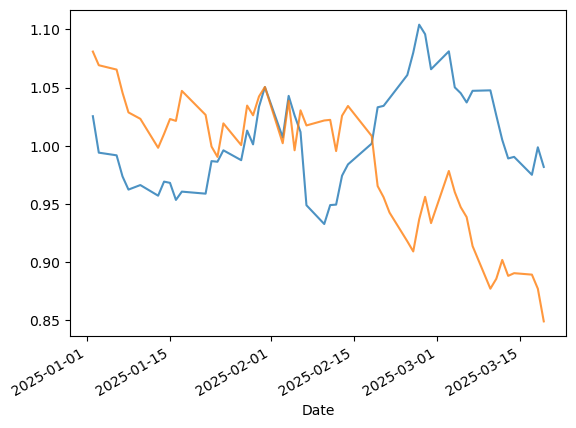

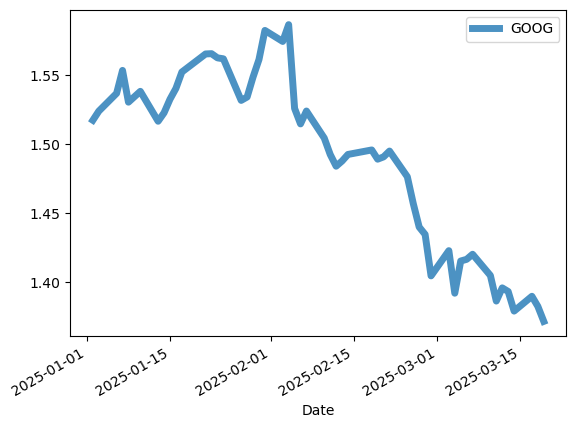

In [3]:
labels = ["NKE", "CMG"]
google = "GOOG"
df = yf.download(labels, start="2025-01-01", end="2025-3-20")
for label in labels:
    (df[("Open", label)]/df[("Open", label)].median()).plot(alpha=0.8,label=label)
df_google = yf.download(google, start="2025-01-01", end="2025-3-20")
(df_google[("Open")]/df_google[("Open")].median() + 0.5).plot(linewidth=5,alpha=0.8,label=google)
plt.legend()

Let predict the Google using the price of the other stocks. We'll assume 
4 different timeseries (like 4 different "stars") here: open, close, high, low.

${\rm Google}_{\rm open}(t) = \theta_{0, t} +
    + \theta_{1, t} {\rm Nike}_{\rm open}(t) +  \theta_{2, t}{\rm Chipolte}_{\rm open}(t) \ldots $

${\rm Google}_{\rm close}(t) = \theta_{0, t} + 
    + \theta_{1, t} {\rm Nike}_{\rm close}(t) +  \theta_{2, t}{\rm Chipolte}_{\rm close}(t) \ldots $


${\rm Google}_{\rm high}(t) = \theta_{0, t} + \ldots $

$\vec y_t = {\mathbf{X}_t} \vec \theta_t$

with 

$${\mathbf{X}_t} = \begin{pmatrix}
1 &  {\rm Nike}_{\rm open}(t) & 
    {\rm Chipolte}_{\rm open} & \ldots \\
1 & {\rm Nike}_{\rm close}(t) & 
    {\rm Chipolte}_{\rm close} & \ldots\\
1 &  {\rm Nike}_{\rm high}(t) & 
    {\rm Chipolte}_{\rm high}& \ldots \\
1 &  {\rm Nike}_{\rm low}(t) & 
    {\rm Chipolte}_{\rm low} & \ldots
\end{pmatrix}
$$

and

$$\theta_t = \begin{pmatrix}
\theta_{0, t}\\
\theta_{1, t}\\
\theta_{2, t}
\end{pmatrix}
$$


Let's look at the data

In [4]:
label_df = df.iloc[:][["Open", "Close", "High", "Low"]]
google_df = df_google.iloc[:][["Open", "Close", "High", "Low"]]
label_df

Price            Open                 Close                  High             \
Ticker            CMG        NKE        CMG        NKE        CMG        NKE   
Date                                                                           
2025-01-02  60.790001  75.866013  59.889999  73.299004  61.160000  76.303799   
2025-01-03  60.130001  73.547748  59.700001  72.940819  60.200001  73.816392   
2025-01-06  59.919998  73.378608  58.799999  71.637421  59.930000  73.945737   
2025-01-07  58.799999  72.035403  57.990002  71.726959  58.950001  73.070167   
2025-01-08  57.849998  71.199629  57.919998  70.930992  58.139999  71.458322   
2025-01-10  57.540001  71.488174  56.500000  70.841446  57.779999  72.025456   
2025-01-13  56.139999  70.811597  56.259998  71.717018  56.480000  72.234396   
2025-01-14  56.810001  71.707061  56.439999  70.811592  56.830002  71.846356   
2025-01-15  57.529999  71.627462  57.369999  70.712097  57.630001  71.886155   
2025-01-16  57.439999  70.542958  58.360001  70.751900  59.110001  70.871298   
2025-01-17  58.889999  71.070286  57.520000  70.483253  58.900002  71.159829   
2025-01-21  57.730000  70.940943  56.200001  72.801521  57.840000  72.901016   
2025-01-22  56.200001  73.010465  55.900002  73.667145  56.310001  74.323817   
2025-01-23  55.700001  72.970665  57.560001  73.915886  57.770000  74.124827   
2025-01-24  57.320000  73.696991  56.700001  73.199509  57.330002  73.876085   
2025-01-27  56.270000  73.070164  58.299999  75.199387  58.480000  75.468024   
2025-01-28  58.180000  74.950650  57.830002  74.015381  58.209999  75.219287   
2025-01-29  57.709999  74.075073  58.270000  76.194351  58.560001  76.721681   
2025-01-30  58.619999  76.462989  58.990002  77.935539  59.570000  78.373318   
2025-01-31  59.080002  77.716647  58.349998  76.512741  59.080002  78.462870   
2025-02-03  56.360001  74.522816  58.360001  76.204300  58.570000  76.303802   
2025-02-04  58.410000  77.159471  59.020000  76.333649  59.189999  77.766399   
2025-02-05  56.020000  75.915765  57.509998  74.194473  58.299999  76.403295   
2025-02-06  57.950001  74.861098  57.320000  71.378723  58.279999  75.020295   
2025-02-07  57.220001  70.204667  57.270000  68.334137  57.880001  70.453408   
2025-02-10  57.459999  69.010711  57.799999  70.582756  59.090000  70.592700   
2025-02-11  57.490002  70.214617  56.180000  70.980736  58.049999  71.627464   
2025-02-12  55.980000  70.244466  57.290001  71.896111  57.400002  72.085149   
2025-02-13  57.689999  72.085149  58.130001  72.841324  58.410000  73.229359   
2025-02-14  58.160000  72.801523  57.080002  72.672180  58.189999  73.129863   
2025-02-18  56.709999  74.124829  54.490002  77.199265  56.779999  77.288815   
2025-02-19  54.290001  76.433141  53.799999  76.393341  54.680000  77.288810   
2025-02-20  53.750000  76.522692  53.049999  76.841080  53.820000  76.880872   
2025-02-21  53.009998  77.010223  51.509998  76.114754  53.130001  77.597248   
2025-02-24  51.619999  78.482766  51.209999  79.875717  51.700001  80.681636   
2025-02-25  51.130001  79.905569  52.470001  81.308472  52.730000  81.547261   
2025-02-26  52.680000  81.686555  53.419998  80.761238  54.599998  82.024847   
2025-02-27  53.770000  81.079626  52.740002  79.617027  54.090000  81.079626   
2025-02-28  52.500000  78.850905  53.970001  79.029999  54.070000  79.617024   
2025-03-03  55.020000  79.989998  54.330002  78.410004  55.700001  80.959999   
2025-03-04  54.000000  77.699997  53.169998  77.320000  54.000000  78.650002   
2025-03-05  53.270000  77.330002  53.599998  77.809998  54.000000  78.309998   
2025-03-06  52.790001  76.739998  51.470001  77.709999  53.500000  78.330002   
2025-03-07  51.389999  77.480003  50.230000  78.589996  51.389999  79.000000   
2025-03-10  49.330002  77.510002  49.830002  76.400002  50.750000  80.190002   
2025-03-11  49.810001  75.910004  49.980000  74.169998  51.299999  76.080002   
2025-03-12  50.720001  74.360001  50.049999  73.580002  51.549999  74.500000   


Now let's pick a time to predict. Again we're trying to predict 4 different values of Google stock using the labels from others stocks.

In [5]:
t = 0
label_time_step_t = label_df.iloc[t].values.reshape(4, len(labels))
google_time_step_t = google_df.iloc[t].values.reshape(4, 1)

In [6]:
label_time_step_t

array([[60.79000092, 75.86601281],
       [59.88999939, 73.2990036 ],
       [61.15999985, 76.30379944],
       [59.68999863, 72.87116873]])

In [7]:
google_time_step_t

array([[191.26709343],
       [190.41307068],
       [192.98013813],
       [188.49525744]])

Set up the ${\mathbf{X}}$ matrix at this timestep:

In [8]:
X_t = np.hstack([np.ones_like(google_time_step_t), label_time_step_t])
X_t

array([[ 1.        , 60.79000092, 75.86601281],
       [ 1.        , 59.88999939, 73.2990036 ],
       [ 1.        , 61.15999985, 76.30379944],
       [ 1.        , 59.68999863, 72.87116873]])

In [9]:
# Computes the vector x that approximately solves the equation a @ x = b
θ_t, resid, _, _ = np.linalg.lstsq(X_t, google_time_step_t, rcond=-1) # set rcond to machine precision

In [10]:
θ_t

array([[-115.17220538],
       [   7.68684152],
       [  -2.12093074]])

Now let's predict four values of Google stock on this date:

In [11]:
X_t @ θ_t 

array([[191.20433962],
       [189.73061924],
       [193.11994764],
       [189.10065319]])

In [12]:
# residuals
X_t @ θ_t  - google_time_step_t

array([[-0.06275382],
       [-0.68245144],
       [ 0.13980951],
       [ 0.60539575]])

Now let's do loop over multiple time steps

In [13]:
len_t = label_df.shape[0]
model_coeffs = np.zeros( ( len_t, len(labels)+1))

In [14]:
for t in range(len_t):
    label_time_step_t = label_df.iloc[t].values.reshape(4, len(labels))
    google_time_step_t = google_df.iloc[t].values.reshape(4, 1)
    X_i = np.hstack([np.ones_like(google_time_step_t), label_time_step_t])
    coeffs, resid, _, _ = np.linalg.lstsq(X_i, google_time_step_t, rcond=-1)
    model_coeffs[t,:] = coeffs.T

n_model_parameters = model_coeffs.shape[1]

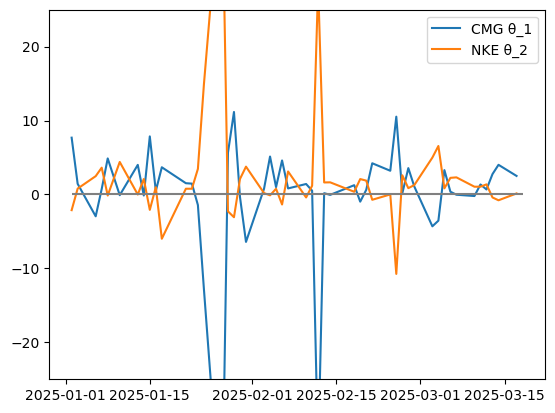

In [15]:
plt.plot(label_df.index[0:50], model_coeffs[0:50, 1],label="CMG θ_1" )
plt.plot(label_df.index[0:50], model_coeffs[0:50, 2], label="NKE θ_2")
plt.hlines([0], xmin=label_df.index[0], xmax=label_df.index[50], color='grey')
plt.ylim(-25,25)
plt.legend()

Now let's try doing the fitting at one timestep by maximizing the likelihood

In [16]:
def generate_google_at_one_timestep(θ, label_data):
    # calulate the target value given the labels
    X_t = np.hstack([1, label_data])
    return X_t @ θ

    
def neg_likelihood(θ_with_sigma, observed, label_data):

    # generate the (negative) log likelihood, given the labels and the observed data
    # and the model parameters  
    θ = θ_with_sigma[0:-1] # model parameters
    sigma_2 = θ_with_sigma[-1] # sigma
    
    model_value = generate_google_at_one_timestep(θ, label_data)
    
    term1 = (-1/2)*(model_value - observed)**2/sigma_2
    term2 = np.log(sigma_2)
    return -1*(term1 + term2)

In [17]:
# 
t0 = 0
cmg_ = 60.790001
nke_ = 75.866013
ggl_ = 191.267093
θ = model_coeffs[t0,:].reshape(1, n_model_parameters).T


label_data = np.array([cmg_, nke_]).reshape(2)
generate_google_at_one_timestep(θ, label_data)

sigma_2 = 0.01 # assume constant noise -- doesn't have to be the case
θ_with_sigma = θ.reshape(3).tolist() + [sigma_2] # merge parameters and noise into a single list

neg_likelihood(θ_with_sigma, ggl_, label_data)
θ

array([[-115.17220538],
       [   7.68684152],
       [  -2.12093074]])

In [18]:
bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000), (0.0001, 1000000))
result = minimize(neg_likelihood, x0=(-120, 10, -5, 0.1), 
                  args=(ggl_,label_data), bounds=bnds, method='SLSQP') # Sequential Least Squares Programming (SLSQP)

In [19]:
result.x

array([-119.19731592,   10.63666075,   -4.43071448,  334.2597995 ])

In [ ]:
θ

In [ ]:
%load_ext watermark

In [ ]:
%watermark -v -p numpy,pandas,yfinance,scipy,matplotlib  -a "J Bloom & D Weisz" -d -t